## Sales Time Series Forecast: Part 2: Training and Validation

### Importing Libraries

In [24]:
from plotly.offline import init_notebook_mode, iplot
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit

### Reading Dataset

In [2]:
df = pd.read_csv('train_preprocessed.csv',low_memory= False)

### Feature Engineering

In [4]:
df = df.set_index('date')

In [5]:
df.index = pd.to_datetime(df.index)

- Dropping unecessary columns after Visualization (Part1).

In [6]:
#df = df.drop(['id','locale','locale_name','description','transferred'],axis= 1)

- Checking Null values from the heatmap

<Axes: >

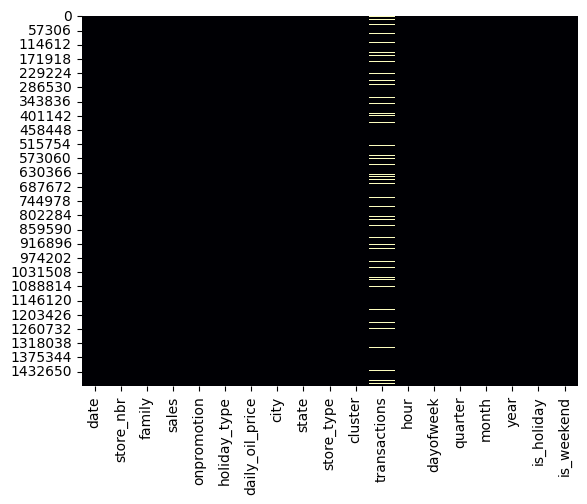

In [ ]:
sns.heatmap(df.isnull(),cmap= 'magma',cbar= False)

- We notice that column transactions has null values so we'll replace the null values with the mean.

In [ ]:
df['transactions'] = df['transactions'].fillna(value = df['transactions'].mean())

- Encoding Categorical Features

In [7]:
from sklearn.preprocessing import LabelEncoder

si = LabelEncoder()

df['family_idx'] = si.fit_transform(df['family'])
df['store_type_idx'] = si.fit_transform(df['store_type'])
df['city_idx'] = si.fit_transform(df['city'])
df['state_idx'] = si.fit_transform(df['state'])
df['holiday_type_idx'] = si.fit_transform(df['holiday_type'])

In [8]:
df = df.drop(['family','holiday_type','city','state','store_type'], axis = 1)

### Splitting Dataset

- Before splitting

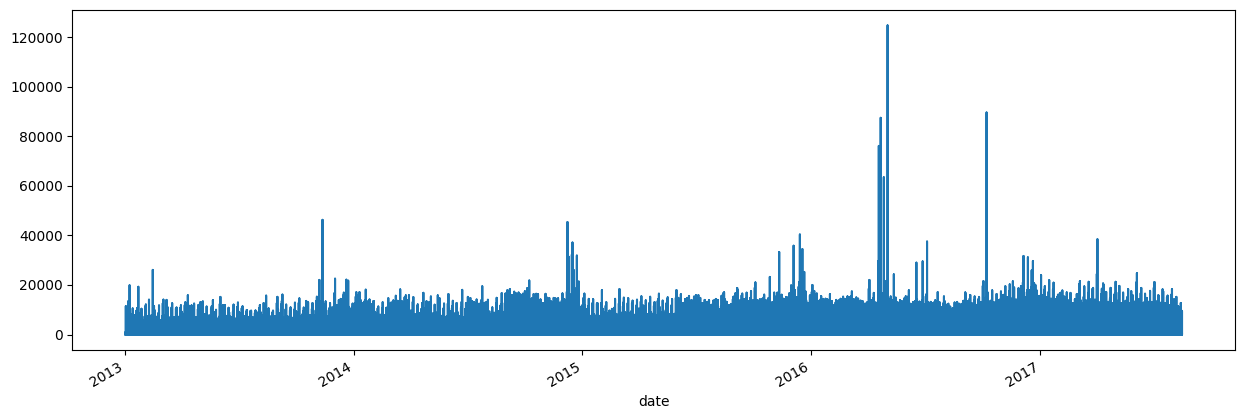

In [9]:
fig, ax = plt.subplots(figsize=(15, 5))
df['sales'].plot(ax=ax)
plt.show()

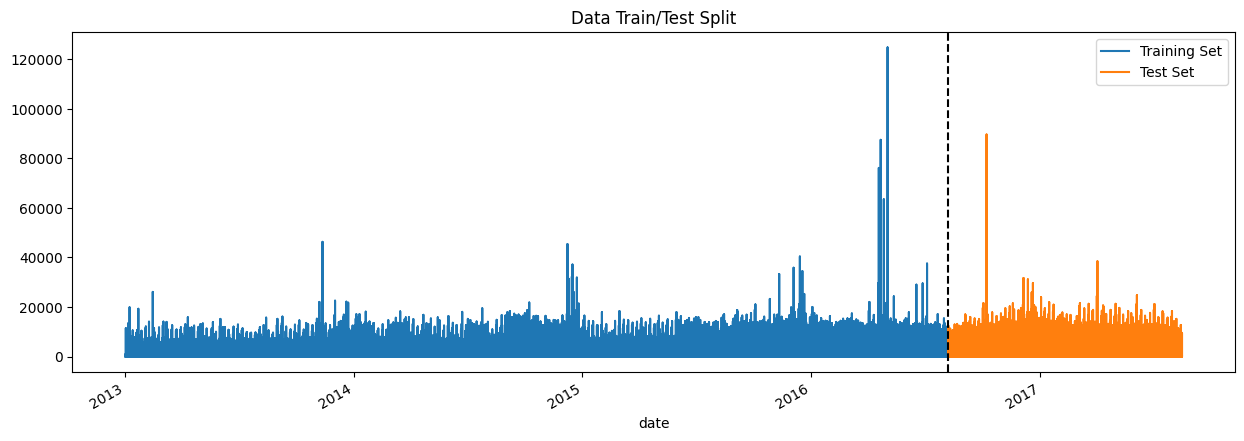

In [61]:
train = df.loc[df.index < '08-07-2016']
val = df.loc[df.index >= '08-07-2016']

fig, ax = plt.subplots(figsize=(15, 5))
train['sales'].plot(ax=ax, label='Training Set', title='Data Train/Test Split')
val['sales'].plot(ax=ax, label='Test Set')
ax.axvline('08-07-2016', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

In [12]:
X_train = train.drop(['sales'], axis=1, inplace=False)
y_train = train['sales']
X_val = val.drop(['sales'], axis=1, inplace=False)
y_val = val['sales']

- Model Training

In [ ]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_val, y_val)],
        verbose=100)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning:

[15:14:36] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.



[0]	validation_0-rmse:1072.56016	validation_1-rmse:1421.23122
[100]	validation_0-rmse:834.28100	validation_1-rmse:1045.67946
[200]	validation_0-rmse:727.37444	validation_1-rmse:920.73334
[300]	validation_0-rmse:646.94840	validation_1-rmse:831.70858
[400]	validation_0-rmse:601.73655	validation_1-rmse:773.30870
[500]	validation_0-rmse:571.73113	validation_1-rmse:729.39154
[600]	validation_0-rmse:550.20500	validation_1-rmse:695.14946
[700]	validation_0-rmse:533.69595	validation_1-rmse:668.94075
[800]	validation_0-rmse:520.17892	validation_1-rmse:646.22039
[900]	validation_0-rmse:509.89128	validation_1-rmse:628.92218
[999]	validation_0-rmse:502.97355	validation_1-rmse:619.03395


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

### Feature Importance

In [ ]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

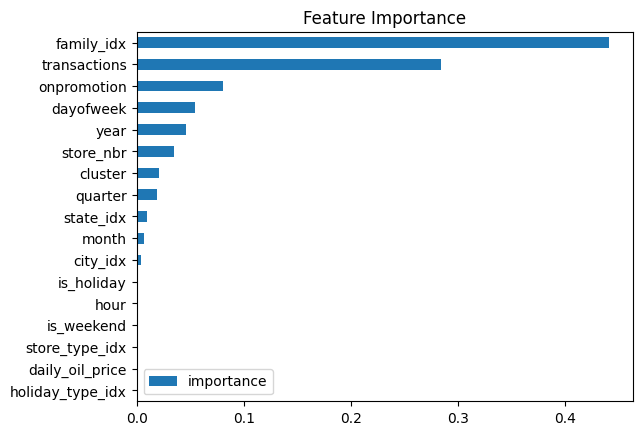

In [ ]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

- Forecast on validation

In [ ]:
val['prediction'] = reg.predict(X_val)

<ipython-input-16-98263895fe04>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



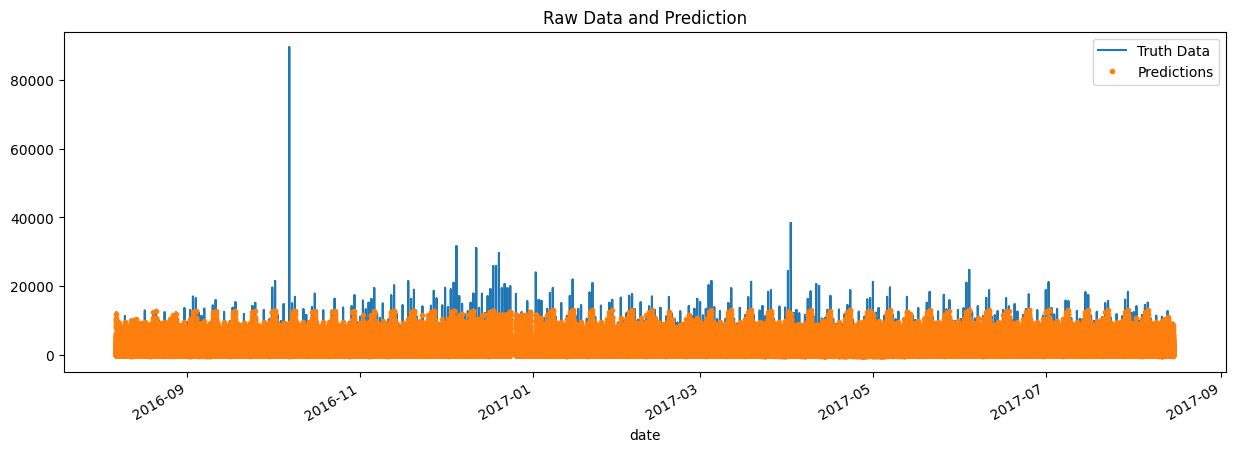

In [ ]:
ax = val[['sales']].plot(figsize=(15, 5))
val['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Prediction')
plt.show()

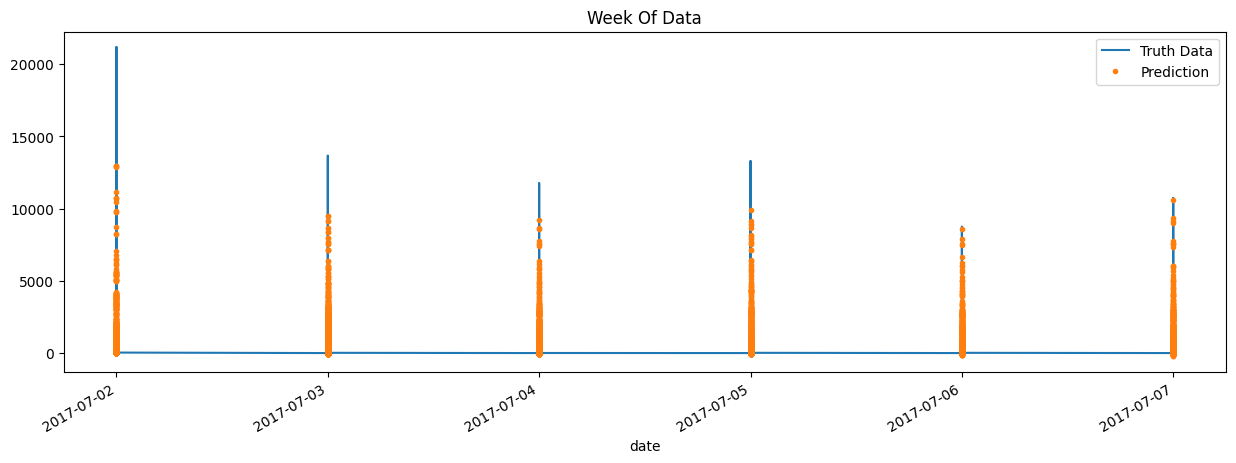

In [ ]:
ax = val.loc[(val.index > '07-01-2017') & (val.index < '07-08-2017')]['sales'] \
    .plot(figsize=(15, 5), title='Week Of Data')
val.loc[(val.index > '07-01-2017') & (val.index < '07-08-2017')]['prediction'] \
    .plot(style='.')
plt.legend(['Truth Data','Prediction'])
plt.show()

### RMSE Score

In [ ]:
score = np.sqrt(mean_squared_error(val['sales'], val['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 619.03


In [ ]:
val[['prediction','sales']].head()

,prediction,sales
date,,
2016-08-07,-0.897824,1.0
2016-08-07,-0.897824,0.0
2016-08-07,-0.897824,1.0
2016-08-07,1811.878906,873.0
2016-08-07,45.636086,0.0


In [ ]:
val['prediction'].describe().T

,prediction
count,675378.000000
mean,532.643250
std,1085.490112
min,-369.084656
25%,40.913177
50%,132.748657
75%,495.094658
max,12958.863281


- Saving the model

In [ ]:
reg.save_model('reg_model.json')

### Retraining the model with selected Features

In [59]:
selected_features = ['family_idx','transactions','onpromotion',
                     'dayofweek','year','store_nbr','cluster','quarter',
                     'state_idx','month','city_idx','daily_oil_price']

In [60]:
target_map = df['sales'].to_dict()
df['lag_7'] = (df.index - pd.Timedelta('7 days')).map(target_map)
df['lag_14days'] = (df.index - pd.Timedelta('14 days')).map(target_map)
df['lag_35days'] = (df.index - pd.Timedelta('35 days')).map(target_map)

In [63]:
features = selected_features+[ 'lag_14days', 'lag_7', 'lag_35days']

In [65]:
X_train = train[features]
y_train = train['sales']
X_val = val[features]
y_val = val['sales']

In [ ]:
reg_2 = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg_2.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_val, y_val)],
        verbose=100)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning:

[21:07:53] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.



[0]	validation_0-rmse:1072.56016	validation_1-rmse:1421.23122
[100]	validation_0-rmse:834.28100	validation_1-rmse:1045.67946
[200]	validation_0-rmse:727.37444	validation_1-rmse:920.73334
[300]	validation_0-rmse:646.94840	validation_1-rmse:831.70858
[400]	validation_0-rmse:601.73656	validation_1-rmse:773.33456
[500]	validation_0-rmse:571.70499	validation_1-rmse:729.43241
[600]	validation_0-rmse:550.25973	validation_1-rmse:695.11959
[700]	validation_0-rmse:534.19701	validation_1-rmse:669.53752


In [69]:
val['prediction'] = reg_2.predict(X_val)

<ipython-input-69-774a95cdc852>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



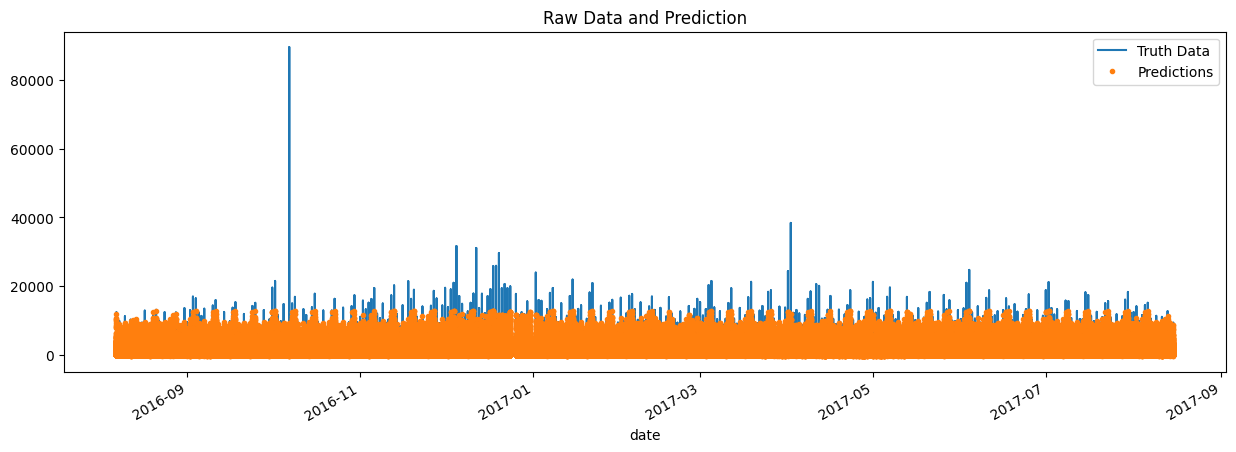

In [70]:
ax = val[['sales']].plot(figsize=(15, 5))
val['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Prediction')
plt.show()

- RMSE score

In [71]:
score = np.sqrt(mean_squared_error(val['sales'], val['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 618.66


- Saving model

In [72]:
reg_2.save_model('reg_2.json')

### Improving Training and Validation by Cross Validation and Lag Features

####Time Series Cross Validation





In [47]:
tss = TimeSeriesSplit(n_splits=5, test_size=24*365*3, gap=24)
df = df.sort_index()

In [48]:
tss

TimeSeriesSplit(gap=24, max_train_size=None, n_splits=5, test_size=26280)

In [49]:
fold = 0
for train_idx, val_idx in tss.split(df):
    print(f"Fold {fold}")
    print("Training indices:", train_idx)
    print("Validation indices:", val_idx)
    fold += 1

Fold 0
Training indices: [      0       1       2 ... 2922921 2922922 2922923]
Validation indices: [2922948 2922949 2922950 ... 2949225 2949226 2949227]
Fold 1
Training indices: [      0       1       2 ... 2949201 2949202 2949203]
Validation indices: [2949228 2949229 2949230 ... 2975505 2975506 2975507]
Fold 2
Training indices: [      0       1       2 ... 2975481 2975482 2975483]
Validation indices: [2975508 2975509 2975510 ... 3001785 3001786 3001787]
Fold 3
Training indices: [      0       1       2 ... 3001761 3001762 3001763]
Validation indices: [3001788 3001789 3001790 ... 3028065 3028066 3028067]
Fold 4
Training indices: [      0       1       2 ... 3028041 3028042 3028043]
Validation indices: [3028068 3028069 3028070 ... 3054345 3054346 3054347]


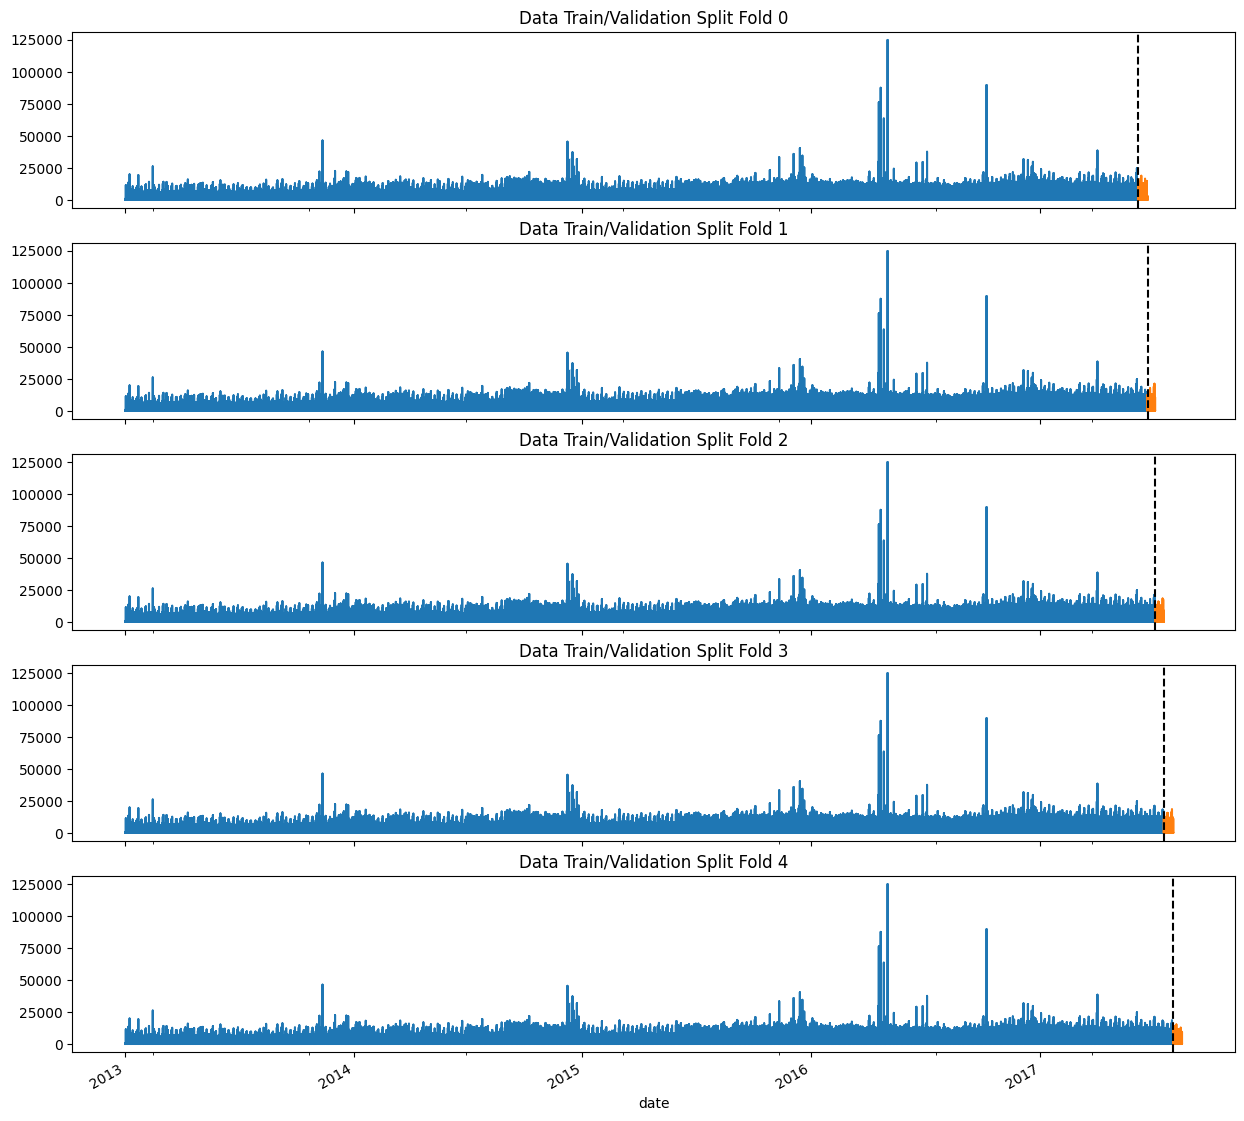

In [50]:
fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    val = df.iloc[val_idx]
    train['sales'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Validation Split Fold {fold}')
    val['sales'].plot(ax=axs[fold],
                         label='Validation Set')
    axs[fold].axvline(val.index.min(), color='black', ls='--')
    fold += 1
plt.show()

#### Lag Features

In [51]:
target_map = df['sales'].to_dict()
df['lag_364days'] = (df.index - pd.Timedelta('364 days')).map(target_map)
df['lag_14days'] = (df.index - pd.Timedelta('14 days')).map(target_map)
df['lag_21days'] = (df.index - pd.Timedelta('21 days')).map(target_map)

In [54]:
df.tail()

,Unnamed: 0,id,store_nbr,sales,onpromotion,daily_oil_price,cluster,transactions,hour,dayofweek,...,is_holiday,is_weekend,family_idx,store_type_idx,city_idx,state_idx,holiday_type_idx,lag_364days,lag_14days,lag_21days
date,,,,,,,,,,,,,,,,,,,,,
2017-08-15,3054343,3000883,9,438.133,0,47.57,6,2155.0,0,1,...,1,0,28,1,18,12,3,17.0,19.316,17.378
2017-08-15,3054344,3000884,9,154.553,1,47.57,6,2155.0,0,1,...,1,0,29,1,18,12,3,17.0,19.316,17.378
2017-08-15,3054345,3000885,9,2419.729,148,47.57,6,2155.0,0,1,...,1,0,30,1,18,12,3,17.0,19.316,17.378
2017-08-15,3054346,3000886,9,121.000,8,47.57,6,2155.0,0,1,...,1,0,31,1,18,12,3,17.0,19.316,17.378
2017-08-15,3054347,3000887,9,16.000,0,47.57,6,2155.0,0,1,...,1,0,32,1,18,12,3,17.0,19.316,17.378


#### Train Using Cross Validation

In [89]:
tss = TimeSeriesSplit(n_splits=5, test_size=24*365*2, gap=24)
df = df.sort_index()

fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    val = df.iloc[val_idx]

    X_train = train[features]
    y_train = train['sales']
    X_val = val[features]
    y_val = val['sales']

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_val, y_val)],
            verbose=100)

    y_pred = reg.predict(X_val)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_val, y_pred))
    scores.append(score)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning:

[21:49:58] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.



[0]	validation_0-rmse:1152.16032	validation_1-rmse:1470.93607
[100]	validation_0-rmse:889.96035	validation_1-rmse:1010.45942
[200]	validation_0-rmse:783.40530	validation_1-rmse:820.05274
[300]	validation_0-rmse:685.72884	validation_1-rmse:717.34192
[400]	validation_0-rmse:632.89651	validation_1-rmse:653.24432
[500]	validation_0-rmse:598.94029	validation_1-rmse:607.33287
[600]	validation_0-rmse:569.55022	validation_1-rmse:568.53515
[700]	validation_0-rmse:551.51745	validation_1-rmse:543.11241
[800]	validation_0-rmse:534.74106	validation_1-rmse:523.37539
[900]	validation_0-rmse:523.70515	validation_1-rmse:507.14619
[999]	validation_0-rmse:516.11196	validation_1-rmse:495.04596


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning:

[21:54:42] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.



[0]	validation_0-rmse:1154.29933	validation_1-rmse:1427.32546
[100]	validation_0-rmse:892.15863	validation_1-rmse:972.36464
[200]	validation_0-rmse:783.69742	validation_1-rmse:798.20451
[300]	validation_0-rmse:684.14347	validation_1-rmse:707.68336
[400]	validation_0-rmse:631.25544	validation_1-rmse:649.69700
[500]	validation_0-rmse:598.72740	validation_1-rmse:611.38326
[600]	validation_0-rmse:569.85542	validation_1-rmse:580.94400
[700]	validation_0-rmse:551.45545	validation_1-rmse:558.64112
[800]	validation_0-rmse:534.85809	validation_1-rmse:540.05884
[900]	validation_0-rmse:523.41111	validation_1-rmse:523.73908
[999]	validation_0-rmse:515.43702	validation_1-rmse:511.35054


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning:

[21:59:13] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.



[0]	validation_0-rmse:1156.08620	validation_1-rmse:1290.66633
[100]	validation_0-rmse:894.10998	validation_1-rmse:837.09598
[200]	validation_0-rmse:786.04443	validation_1-rmse:669.34210
[300]	validation_0-rmse:685.67949	validation_1-rmse:590.39213
[400]	validation_0-rmse:633.87165	validation_1-rmse:542.38228
[500]	validation_0-rmse:598.50755	validation_1-rmse:509.72600
[600]	validation_0-rmse:569.24361	validation_1-rmse:484.69184
[700]	validation_0-rmse:551.33867	validation_1-rmse:466.20589
[800]	validation_0-rmse:534.49403	validation_1-rmse:450.97728
[900]	validation_0-rmse:523.74391	validation_1-rmse:438.87503
[999]	validation_0-rmse:516.07544	validation_1-rmse:428.08704


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning:

[22:03:40] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.



[0]	validation_0-rmse:1156.91700	validation_1-rmse:1461.63809
[100]	validation_0-rmse:895.99770	validation_1-rmse:1005.29814
[200]	validation_0-rmse:786.67721	validation_1-rmse:823.18403
[300]	validation_0-rmse:687.29133	validation_1-rmse:716.61864
[400]	validation_0-rmse:634.42921	validation_1-rmse:654.44754
[500]	validation_0-rmse:600.20180	validation_1-rmse:613.75477
[600]	validation_0-rmse:569.90235	validation_1-rmse:578.51213
[700]	validation_0-rmse:552.19100	validation_1-rmse:556.60648
[800]	validation_0-rmse:535.92640	validation_1-rmse:536.63642
[900]	validation_0-rmse:524.62398	validation_1-rmse:519.67624
[999]	validation_0-rmse:517.09014	validation_1-rmse:509.06617


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning:

[22:08:09] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.



[0]	validation_0-rmse:1158.85465	validation_1-rmse:1271.19722
[100]	validation_0-rmse:896.70690	validation_1-rmse:869.12222
[200]	validation_0-rmse:786.41029	validation_1-rmse:737.23671
[300]	validation_0-rmse:687.32156	validation_1-rmse:641.36369
[400]	validation_0-rmse:635.70128	validation_1-rmse:584.91153
[500]	validation_0-rmse:602.13366	validation_1-rmse:546.79991
[600]	validation_0-rmse:571.76879	validation_1-rmse:513.50695
[700]	validation_0-rmse:553.37567	validation_1-rmse:491.46213
[800]	validation_0-rmse:535.79382	validation_1-rmse:473.41932
[900]	validation_0-rmse:524.81712	validation_1-rmse:459.91198
[999]	validation_0-rmse:516.55061	validation_1-rmse:449.34417


In [90]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 478.5788
Fold scores:[495.04596144407003, 511.35053409855766, 428.08704058063887, 509.0661686375114, 449.34417145267224]


- Saving model with cross validation training


In [91]:
reg.save_model('cross_val_model.json')

### Submission File for the kaggle competition

In [74]:
test= pd.read_csv('test_preprocessed.csv')

- Preparing test df

In [76]:
from sklearn.preprocessing import LabelEncoder

si = LabelEncoder()
test['family_idx'] = si.fit_transform(test['family'])
test['store_type_idx'] = si.fit_transform(test['store_type'])
test['city_idx'] = si.fit_transform(test['city'])
test['state_idx'] = si.fit_transform(test['state'])
test['holiday_type_idx'] = si.fit_transform(test['holiday_type'])

In [77]:
test = test.drop(['family','holiday_type','city','state','store_type'], axis = 1)

In [79]:
test= test.set_index('date')
test.index = pd.to_datetime(test.index)

- Since the test df doesn't have lag features (no column sales), we need to align it with training df so they could have the same column names

In [81]:
df, test = df.align(test, join='left', axis=1, fill_value=0)

In [92]:
X_test = test[features]

In [93]:
test['pred'] = reg.predict(X_test)

In [94]:
submission = pd.DataFrame({
    'id': test['id'],
    'sales': test['pred']
})

In [95]:
submission.head()

,id,sales
date,,
2017-08-16,3000888,280.960022
2017-08-16,3000889,280.960022
2017-08-16,3000890,837.862244
2017-08-16,3000891,9365.042969
2017-08-16,3000892,828.805908


-  Save the submission to a CSV file


In [96]:
submission.to_csv('submission.csv', index=False)